# Coding Discussion #6
### Nikhila Iyer
### November 21, 2021

## Dependencies

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

## Data

In [31]:
# Load in the data
train_dta = pd.read_csv("/Users/nikhilaiyer/Documents/GRAD SCHOOL/ppol564/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv") # Training data
test_dta = pd.read_csv("/Users/nikhilaiyer/Documents/GRAD SCHOOL/ppol564/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv") # Test data

train_dta.head()

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,78021,4061N 0085,3.0,1.0,1.0,Forced Air,Y,1.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,11,2234,2018-07-22T18:01:43.000Z,13.591116
1,28783,1587 0075,2.0,1.0,7.0,Warm Cool,Y,1.0,7.0,3.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,3850,2018-07-22T18:01:43.000Z,12.730801
2,35035,2024 0817,2.0,2.0,13.0,Hot Water Rad,Y,1.0,9.0,4.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,7866,2018-07-22T18:01:43.000Z,13.651814
3,67983,3736 0059,1.0,1.0,7.0,Warm Cool,Y,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,2739,2018-07-22T18:01:43.000Z,12.860999
4,8791,0817 0826,2.0,0.0,13.0,Hot Water Rad,N,1.0,11.0,4.0,...,6.0,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2097,2018-07-22T18:01:43.000Z,14.100690


### Cleaning

<AxesSubplot:>

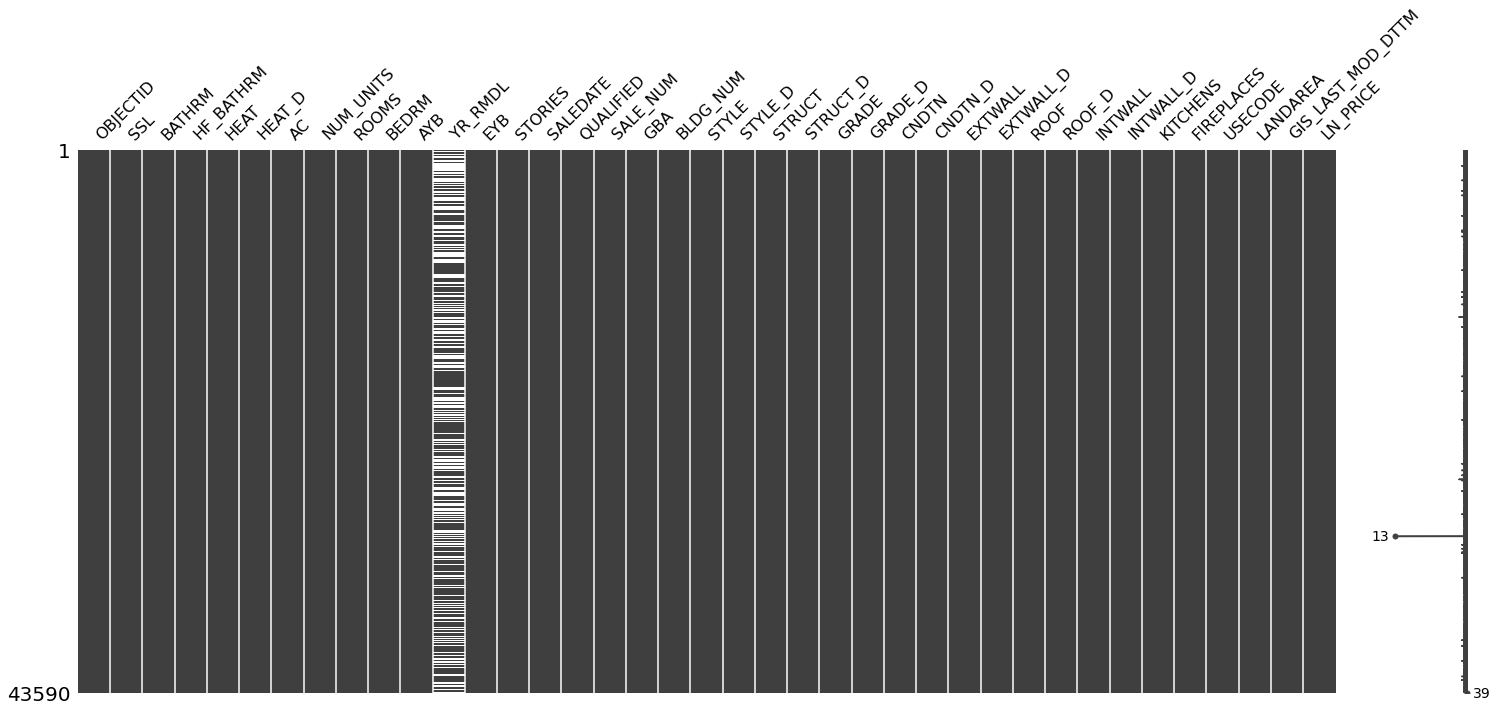

In [32]:
# Look at the missingness in the data
miss.matrix(train_dta)

Looks like the only place we have a lot of missingness is in the YR_RMDL, which is probably because not all the houses have not been remodeled.

In [33]:
def data_cleaner(dta):
    '''
    This function cleans the data by taking in a data set and then returning a data set that does not have NA values,
    and removes observations where the outcome is missing.
    
    Arguments
    ----------
    df: A dataset with all the home selling data (most likely the training or test data)
   
    Returns
    ----------
    df: A cleaned dataset with only houses that have been sold and observations that do not have missing data
    
    '''
    # Only consider houses that have been sold in each data set
    dta = dta[dta.LN_PRICE > 0]

    # Drop all observations where the outcome is missing in each data set
    dta = dta[~dta.LN_PRICE.isna()]

    # Drop missing values
    dta = dta.dropna()

    return dta

In [35]:
# Put the training and test data through the data_cleaner function
train_dta = data_cleaner(train_dta)
test_dta = data_cleaner(test_dta)

#train_dta.head()

In [36]:
# Set the outcome and predictor variables in each data set
# OUTCOME: selling price, logged
train_y = train_dta['LN_PRICE']
test_y = test_dta['LN_PRICE']

# PREDICTORS: number of bathrooms, number of bedrooms, land area
train_x = train_dta[['BATHRM', 'BEDRM', 'LANDAREA']]
test_x = test_dta[['BATHRM', 'BEDRM', 'LANDAREA']]

# Fix the land area variable scale
train_x['LANDAREA'] = np.log(train_x['LANDAREA'])
test_x['LANDAREA'] = np.log(test_x['LANDAREA'])

### Exploration

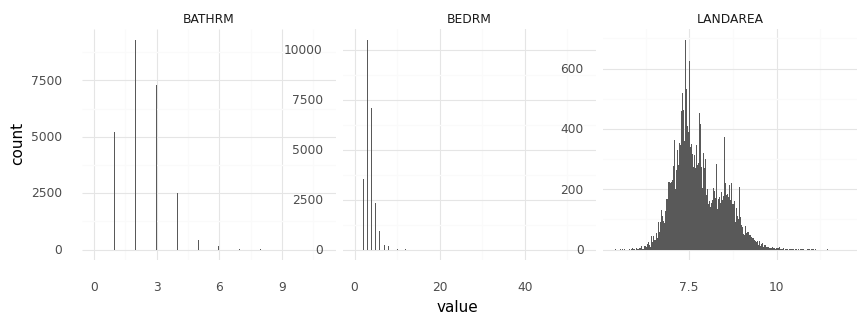

<ggplot: (300010237)>

In [7]:
# Distributions of the training data set
(
    ggplot(train_x.melt(),aes(x = "value")) +
    geom_histogram() +
    facet_wrap("variable", scales = "free") +
    theme_minimal() +
    theme(figure_size = (10, 3))
)

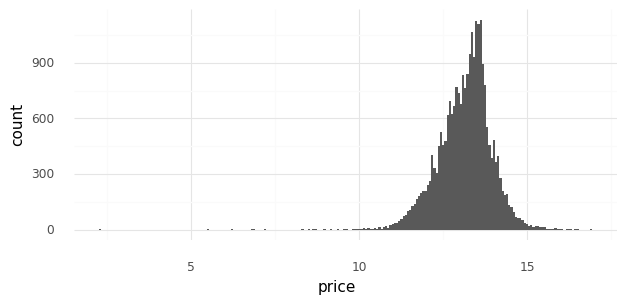

<ggplot: (299766176)>

In [8]:
# Look at price distribution for any red flags
(
    ggplot(pd.DataFrame(dict(price=train_y)),
           aes(x="price")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3))
)

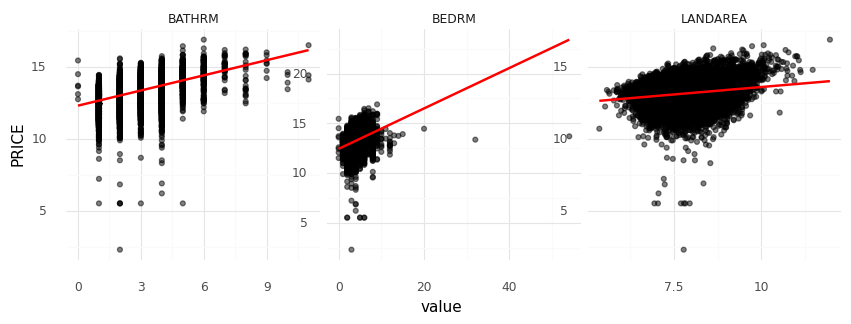

<ggplot: (300059552)>

In [9]:
# Look to see how our predictors relate to the outcome
D = train_x.copy()
D['PRICE'] = train_y

(
    ggplot(D.melt(id_vars = ["PRICE"]),
           aes(x = "value",y = "PRICE"))+
    geom_point(alpha = .5) +
    facet_wrap("variable",scales = "free") +
    geom_smooth(method = "lm",se = False,color = "red") +
    theme_minimal() +
    theme(figure_size = (10,3))
)

### Pre-Processing

For now let's rescale the data so we have all the models individually to see the decision tree (specifically) and the box and whisker plot (a good visual to see which model is working best pre tuning). Further down we'll put everything into the modeling pipeline for ease of use.

In [10]:
# Rescale the data
scaler = pp.MinMaxScaler()
col_names = list(train_x)
train_x = scaler.fit_transform(train_x)

# Convert back into a dataframe
train_x = pd.DataFrame(train_x, columns=col_names)
train_x.head()

,BATHRM,BEDRM,LANDAREA
0,0.272727,0.074074,0.354963
1,0.181818,0.074074,0.546214
2,0.181818,0.074074,0.345348
3,0.272727,0.074074,0.365790
4,0.272727,0.055556,0.279556


## Modeling

In [11]:
# to estimate test error we are using K-fold cross-validatio
# this generator is to ensure we're using the same break points when training the model
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# using mean squared error as our performance metrics
use_metrics = ["neg_mean_squared_error"]

### Run the Models

In [12]:
# Linear model
lm_scores = cross_validate(LM(),train_x,train_y, cv = fold_generator, scoring = use_metrics)

In [13]:
# KNN model
knn_scores = cross_validate(KNN(),train_x,train_y, cv = fold_generator, scoring = use_metrics)

In [14]:
# Decision tree
dt_scores = cross_validate(DTree(),train_x,train_y, cv = fold_generator, scoring = use_metrics)

Just for practice in sklearn and visibility, let's plot a decision tree:

In [15]:
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_x,train_y) # Fit the mode

# Plot the tree
plt.figure(figsize=(12, 8),dpi=300)
rules = tree.plot_tree(mod, feature_names = col_names, fontsize = 25)

In [16]:
# Bagging
bag_scores = cross_validate(Bag(),train_x,train_y, cv = fold_generator, scoring = use_metrics)

In [17]:
# Random forest
rf_scores = cross_validate(RF(),train_x,train_y, cv = fold_generator, scoring = use_metrics)

### Compare the Models

In [18]:
# Collect all the metrics we care about as a dictionary
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

In [19]:
# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.493069
1,lm,0.471447
2,lm,0.480678
3,lm,0.495225
4,lm,0.456219
5,knn,0.531638
6,knn,0.511681
7,knn,0.527044
8,knn,0.547067
9,knn,0.484794


In [20]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

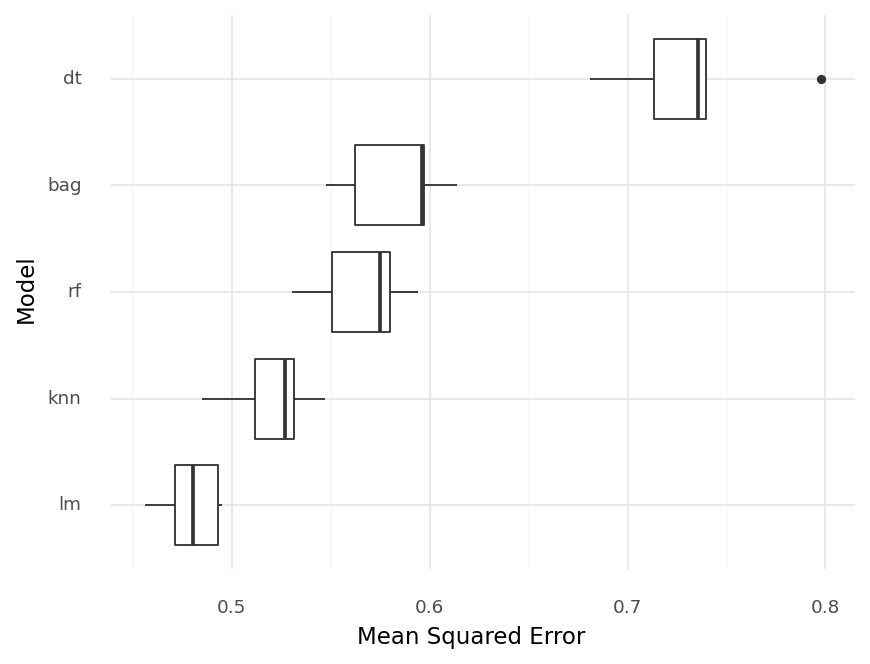

<ggplot: (300777668)>

In [21]:
# Plot the models in a box and whisker plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

Based on this plot, looks like the linear model has the lowest mean squared error, while the decision tree has the highest.

### Tuning hyper parameters
Let's look at the K values, which determines the degree to which we overfit or underfit the data

In [22]:
set_k = dict()
for k in [1, 5, 10, 50, 100, 250]:
    score = cross_validate(KNN(n_neighbors = k),
                           train_x, train_y,
                           cv = fold_generator,
                           scoring = use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()

set_k

{1: -0.8322093095552281,
 5: -0.5204447956512558,
 10: -0.47500363564954295,
 50: -0.4433841647434223,
 100: -0.442940838797446,
 250: -0.44533928600833506}

As we can see, k = 50 is the best sample fit value.

## Modeling Pipeline
From here let's just create the seamless pipeline for modeling now that we've seen all the interesting visualizations!

In [37]:
# (1) Set the folds index to ensure comparable samples
# We actually already completed this step above!
fold_generator = KFold(n_splits = 5, shuffle = True,random_state = 111)


# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','BEDRM','LANDAREA'])])

# (3) Next create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters.
search_space = [
    # Linear Model
    {'model' : [LM()]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},

    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},

    # The Bagging decision tree model
    {'model': [Bag()]},

    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'BEDRM',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=30)],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [1, 2, 3, 5]},
                         {'model': [BaggingR

In [24]:
# Look at the best fit score from the scan
search.best_score_ # Mean out-of-sample (CV) error

-0.4480662715322518

In [25]:
# Look at the best model
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

## Test the Performance
Let's use the modeling pipeline on the test data (data that it wasn't previously used on) to see how well it works.

In [38]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)
m.mean_squared_error(test_y, pred_y)

0.4382831423442768

In [39]:
m.r2_score(test_y, pred_y)

0.27676652953073255

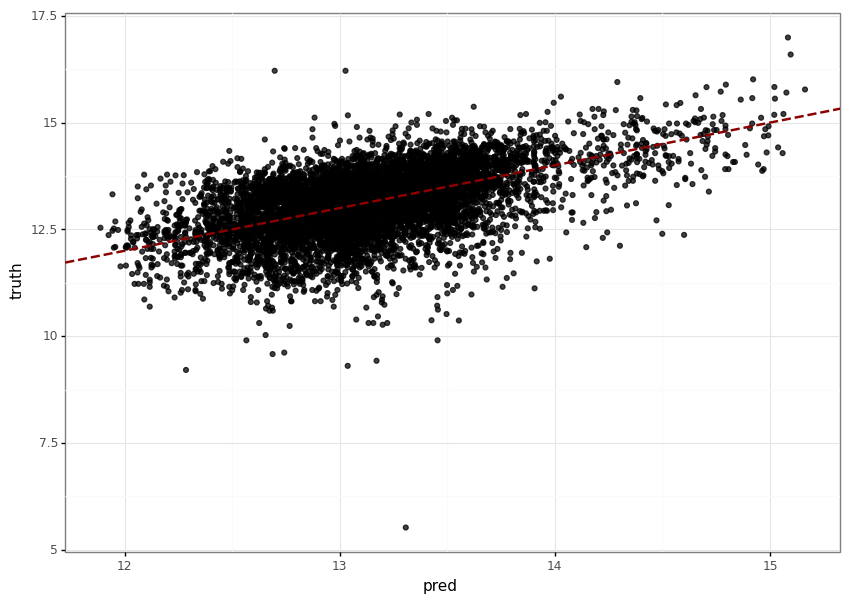

<ggplot: (300312055)>

In [40]:
# Plot
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

The mean squared error here is 0.438 while the r-squared is 0.276.